# Principal Component Analysis

One of the simplest and most widely used techniques in machine learning is principal component analysis (PCA). PCA is a tool for understanding the variance in a dataset&mdash;i.e., what are the main ways that observations in the dataset vary.

To introduce the basic idea, imagine that you are given a dataset from a colleague who is investigating a new species of moth recently discovred in the Pacific Northwest of the United States and Canada. The dataset contains three variables (columns) and 1,000 observations (rows) of measurements of the sizes (in square millimeters) of three different spots that appear on the moths' wings (the Reniform, Claviform, and Orbicular spots). Each row represents a different moth whose spots were measured, and each column represents one of the three spots. (This example dataset is not real: it was artificially generated for this demonstration.)

At first glance, the data do not appear unusual. You examine the mean and standard deviation of each spot's size and find the following:

|Spot Name|Mean|Standard Deviation|
|:--:|:--:|:------:|
|Reinform Spot | 18 mm$^2$| 1.9 mm$^2$|
|Claviform Spot|  7 mm$^2$| 1.4 mm$^2$|
|Orbicular Spot|  4 mm$^2$| 0.7 mm$^2$|

You might suspect that there is some covariance in the spots, so you might go ahead and make plots of each size versus each other. We can read in the data ourselves and try this. To start with, let's read in the CSV files containing the data:

In [138]:
import pandas as pd

# Import the moth data using Pandas:
moth_data = pd.read_csv('moth_data.csv')

# Display the loaded dataframe:
moth_data

reniform_size  claviform_size  orbicular_size
0        18.396847        9.383858        3.071913
1        17.255669        8.037941        3.949495
2        19.005889        7.842778        3.311098
3        19.157011        9.636824        2.691104
4        18.834700        9.302617        2.989798
..             ...             ...             ...
995      18.186429        7.570739        3.901942
996      16.398813        7.703396        4.490830
997      17.883925        7.212499        3.983604
998      18.503120        4.891885        4.250488
999      19.162001        5.702917        3.804683

[1000 rows x 3 columns]

We can now plot each spot's size versus each other spot's size:

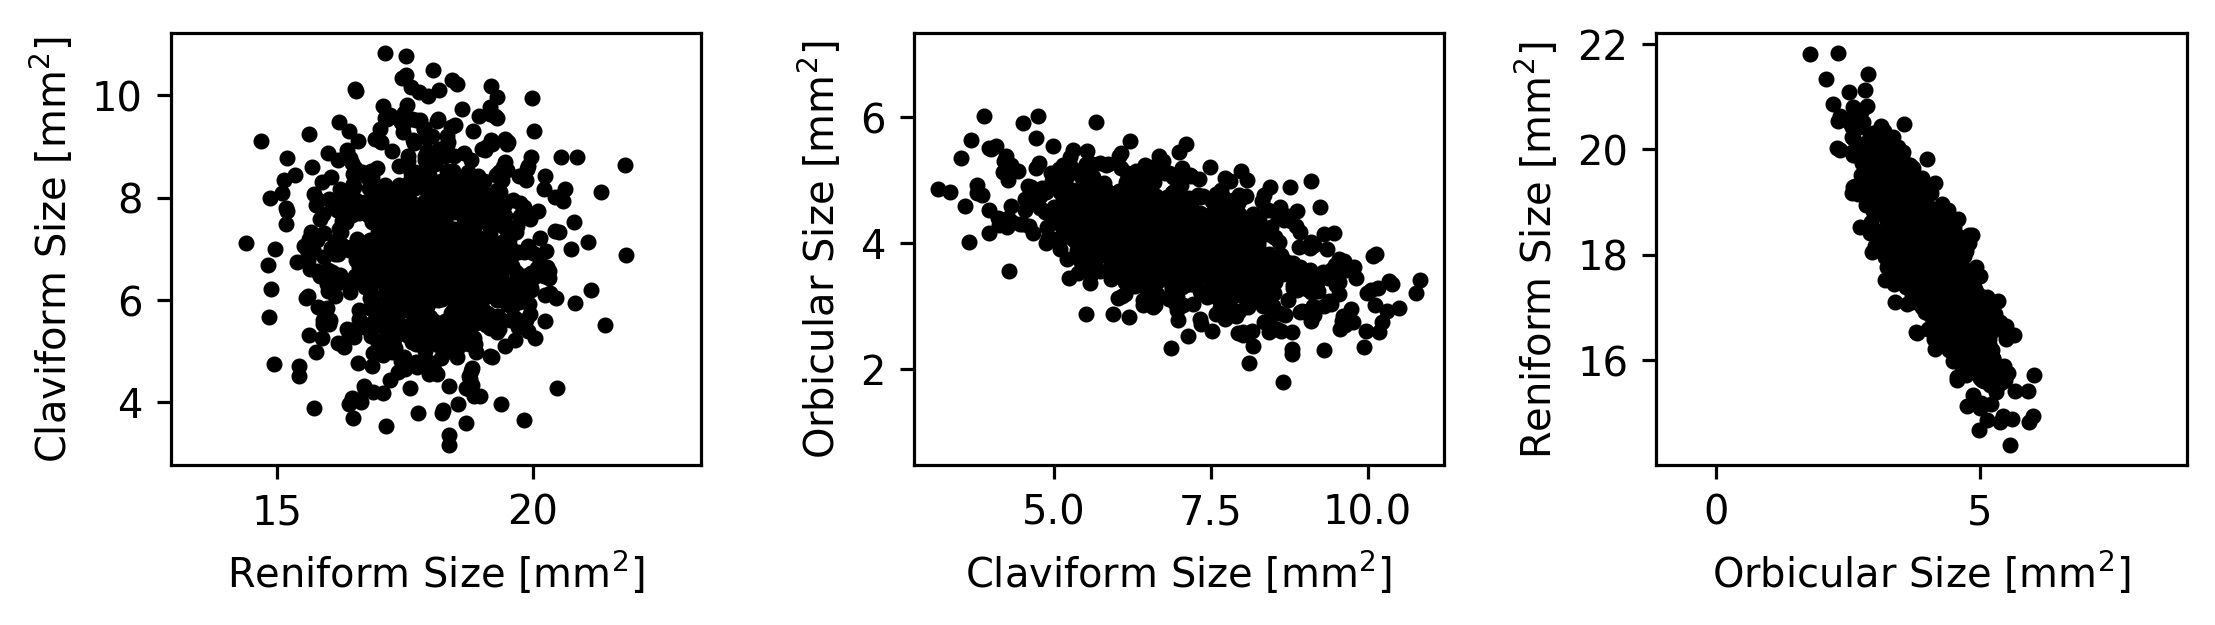

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the sizes from the dataframe; there are 3 sizes, so this yeilds a
# matrix that is 1000 x 3:
coords = moth_data.to_numpy()
coords = coords.T
(x,y,z) = coords

# The labels we'll use for the plot axes:
axlbls = [
    r'Reniform Size [mm$^2$]',
    r'Claviform Size [mm$^2$]',
    r'Orbicular Size [mm$^2$]']

# Make the plot:
(fig,axs) = plt.subplots(1, 3, figsize=(7,1.5), dpi=288)
fig.subplots_adjust(0,0,1,1,0.4,0)

axs[0].plot(x, y, 'k.')
axs[0].set_xlabel(axlbls[0])
axs[0].set_ylabel(axlbls[1])

axs[1].plot(y, z, 'k.')
axs[1].set_xlabel(axlbls[1])
axs[1].set_ylabel(axlbls[2])

axs[2].plot(z, x, 'k.')
axs[2].set_xlabel(axlbls[2])
axs[2].set_ylabel(axlbls[0])

for ax in axs:
    ax.axis('equal')

plt.show()

However, imagine that next you make a 3D animation of the data to get a better sense for its overall structure.

When you view the animation, it looks like this:

In [143]:
# This code-block generates a 3D animation of the points in the moth dataset.
# It is hidden in the lesson because understanding this code-block is not
# required to understand the lesson!

(fig,ax) = plt.subplots(1, 1, figsize=(2,2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)
framecount = 300
coordplot = ax.scatter(
    coords[0], coords[2],
    c='k', ec=None, s=(1.4+coords[1]))
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
y0 = coords[1] - np.mean(coords[1])
xz0 = coords[[0,2],:]
xz0 = xz0 - np.mean(xz0, axis=1)[:,None]
def _draw_frame(frame):
    points = coords[[0,2],:]
    axspts = np.array([[1,0],[0,1]])
    # Rotate the points
    th = 2*np.pi*frame / (framecount - 1)
    rmtx = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    points = rmtx @ xz0
    coordplot.set_offsets(np.c_[points[0], y0])
    #print(np.min(points[1]), np.max(points[1]))
    ptsz = (12 - (points[1] + 5.5)).astype(int)
    ptsz = np.where(ptsz < 1, 1, ptsz)
    coordplot.set_sizes(ptsz)
    return (coordplot,)

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
anim = FuncAnimation(
    fig,
    _draw_frame,
    frames=framecount,
    interval=20,
    blit=True)

display(HTML(anim.to_jshtml(default_mode='loop')))
plt.close(fig)

**What do you find interesting about these measurements?**

```{dropdown} Some possible answers...

* **The measurements are flat when viewed from the right angle**. This means that they are highly dependent on each other&mdash;they cannot all vary independently.
* **There are no real outliers**. The data are very normally distributed and don't contain major outliers.
* **The dataset has a strong central tendency**. Most of the moths have measurements that are very near the mean.
```

Whatever else you notice about these points, they are very flat when viewed from a particular angle. What does this mean?

One answer is that the measurements have only 2 *degrees of freedom*, despite consisting of three spot measurements per buttefly. This is because the sizes of the spots have strong covariance and depend on each other. It would be useful to be able to describe how the three spot measurements depend on each other and how they each contribute to the two dimensions along which they vary.

**Principal component analysis (PCA)** is a powerful tool for explain this kind of variance.

## What does PCA do?

PCA performs a transformation (a translation plus a rotation) of the input data that ensures the following:
* The mean of the dataset is the origin.
* The $x$-axis points in whatever direction maximizes the variance of your data along it.
* The $y$-axis points in whatever direction maximizes the data's *remaining variance* along it, while still keeping the $x$-axis pointing in the direction of maximum variance and keeping the $x$ and $y$ axes orthogonal.
* For additional dimensions, the same is true: each axis of the data is pointed in whatever direction maximizes the remaining variance along it while keeping the previous axes aligned with their direction of maximum variance.

Let's look at an example using the simulated dataset of butterfly spot measurements we examined above.

### What does PCA do: an example in 2 Dimensions

Let's take a look at just the Reniform and Orbicular spot sizes (the $x$ and $z$ coordinates that we extracted earlier) from the moth dataset. If we plot the values, we can see that most of the variation in the dataset lies along a single axis.

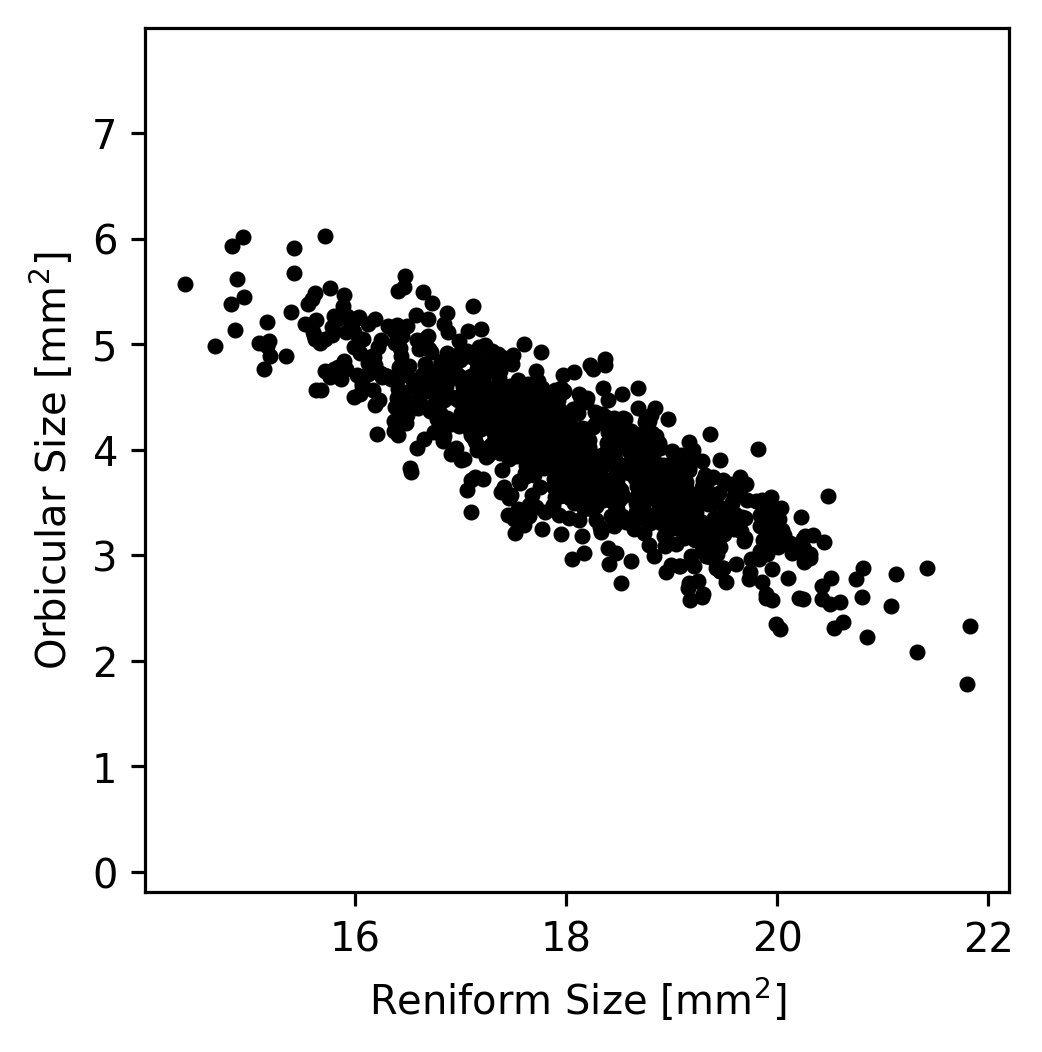

In [145]:
(fig,ax) = plt.subplots(1, 1, figsize=(3,3), dpi=288)
fig.subplots_adjust(0,0,1,1,0.4,0)

ax.plot(x, z, 'k.')
ax.set_xlabel(axlbls[0])
ax.set_ylabel(axlbls[2])
ax.axis('equal')

plt.show()

In theory, if we wanted to understand how the Reniform and Orbicular spot sizes were related to each other, we could start by subtracting the mean Reniform size from the Reniform sizes and the mean Orbicular size from the Orbicular sizes; this would result in data centered at zero. (This simplifies the dataset somewhat but does not change it's appearance.)

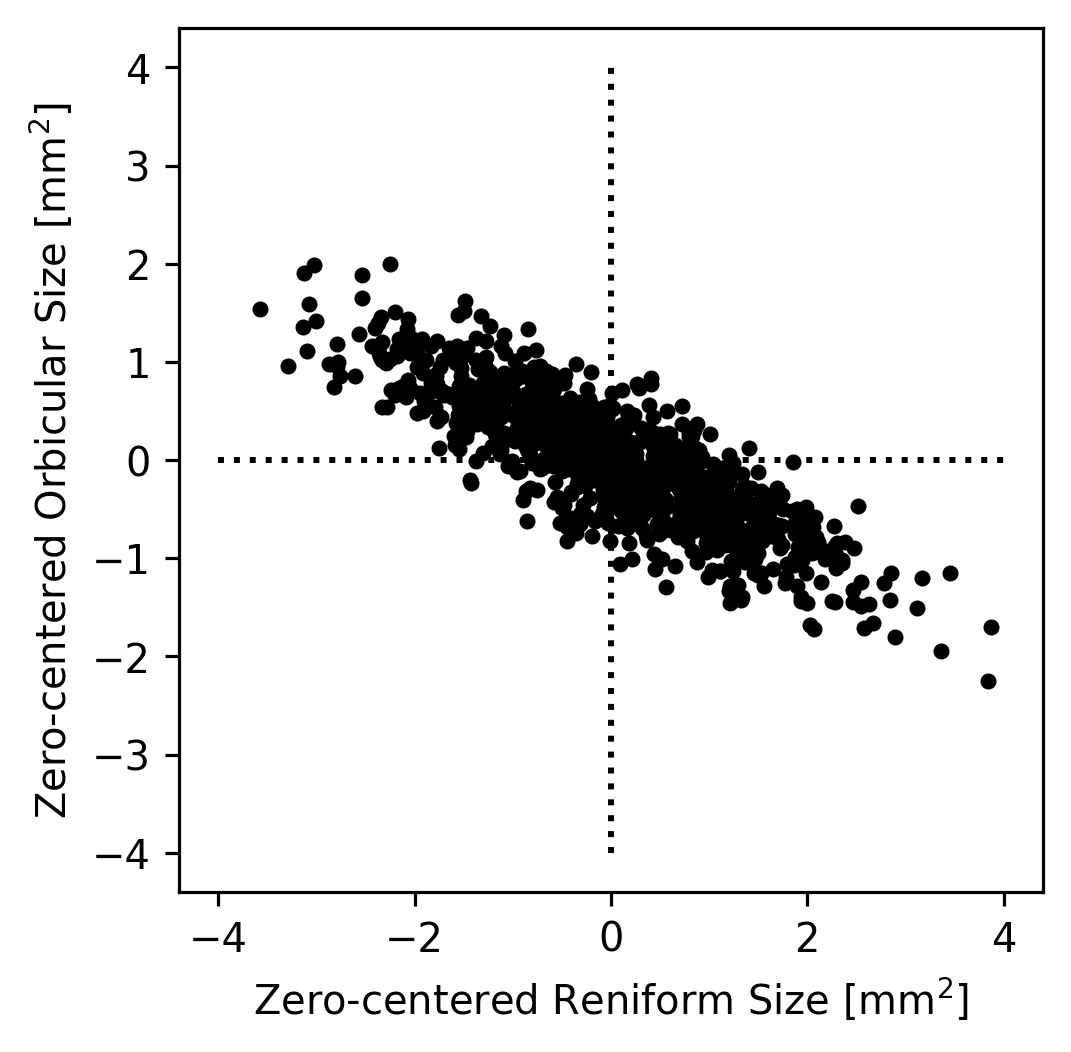

In [147]:
(fig,ax) = plt.subplots(1, 1, figsize=(3,3), dpi=288)
fig.subplots_adjust(0,0,1,1,0.4,0)

ax.plot(x - np.mean(x), z - np.mean(z), 'k.')

# Plot x/y axes as dotted lines.
ax.plot([-4,4], [0,0], 'k:')
ax.plot([0,0], [-4,4], 'k:')

# Plot decoration.
ax.set_xlabel("Zero-centered " + axlbls[0])
ax.set_ylabel("Zero-centered " + axlbls[2])
ax.axis('equal')

plt.show()

We could then imagine that all of the true datapoints were actually on a single line but that they appear to be a cloud because of noise in the measurements. For example, maybe the Orbicular spot's size is always equal zero-centered Reniform Spot's size divided by $-2$. Since the zero-centered Reniform size is our $x$-axis and the zero-centered Orbicular size is our $y$ axis, this implies that $y = x / -2$. We can plot this axis to see how it looks as an explanation of our data.

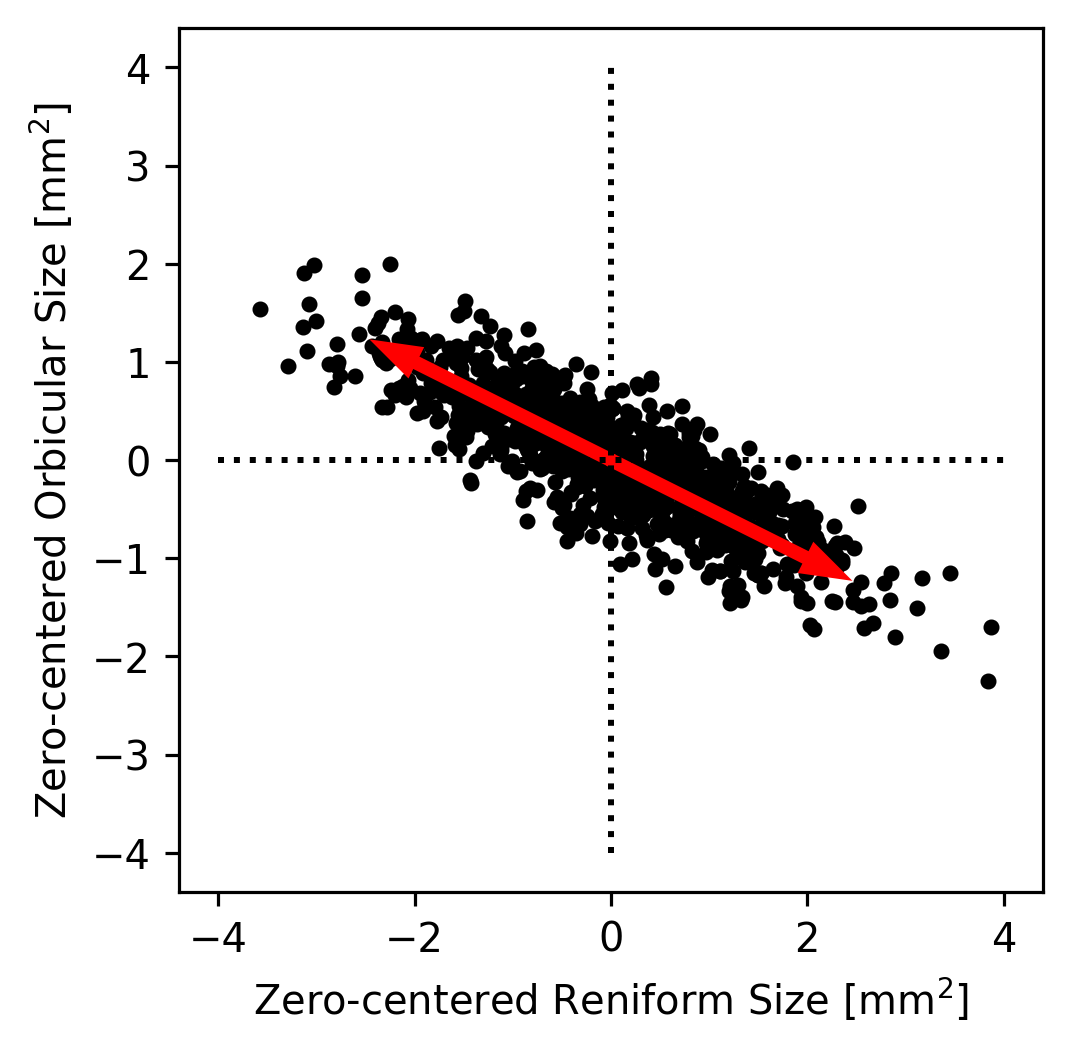

In [155]:
(fig,ax) = plt.subplots(1, 1, figsize=(3,3), dpi=288)
fig.subplots_adjust(0,0,1,1,0.4,0)

ax.plot(x - np.mean(x), z - np.mean(z), 'k.')

# Plot arrows representing y = -x/2
ax.arrow(0, 0, 2, -1, color='r', zorder=2, width=0.1)
ax.arrow(0, 0, -2, 1, color='r', zorder=2, width=0.1)

# Plot x/y axes as dotted lines.
ax.plot([-4,4], [0,0], 'k:')
ax.plot([0,0], [-4,4], 'k:')

# Plot decoration.
ax.set_xlabel("Zero-centered " + axlbls[0])
ax.set_ylabel("Zero-centered " + axlbls[2])
ax.axis('equal')

plt.show()

That pair of arrows looks pretty close to the direction that's most line-like in the data! Had we made a bad guess about the direction, we could have tried a few different directions until we found one that seemed to capture the main trend in the data. This axis is called the **first principal component** of the dataset because it's the axis along which the most variance lies.

The direction here might be off by a few degrees, but we can be pretty certain that it's not off by very much just by looking at it. However, what if the data had been more circular (like the plot we made earlier of the Claviform versus the Reniform spot sizes)? It would be very hard to tell just by eye what direction best captures the data's trend. If it's not obvious by eye where the trend in a dataset lies, what do we do?

One option would be to write a quick algorithm that tried many directions and returned the direction that maximized the variance in the direction of the arrows. This is somewhat slow, but with enough precision it would work! What if your dataset has more than 2 dimensions, however?

PCA is a general technique for quickly performing the calculations being described here. It returns a list of axes, one per dimension of the dataset, that are sorted in order from the axis along which most of the variance in the dataset lies (PC1) to the axis along which the least variance lies (the last PC). All of the PCs are orthogonal to all others, so they make a valid cartesian coordinate system just like the standard $x$-, $y$-, and $z$-axes.

PCA also typically returns a list of singular values, which represent the amount of variance from the dataset lies in the direction of each principal axis. Because the total variance in a dataset is equal to the sum of the variance along each orthogonal dimension (see [here](https://math.stackexchange.com/a/4664752/247901) for an explanation), the sum of these values is equal to the variance of the dataset. In other words, PCA partitions the dataset into a set of orthogonal axes that are sorted by the amount of variance they encapsulate. Because the initial dataset is also defined on orthogonal axes, this is essentially a rotation of the dataset onto a new set of axes (possibly with some reflection as well).

### PCA Example Using `scikit-learn` 

In [169]:
# Import the PCA algorithm from scikit-learn:
from sklearn.decomposition import PCA

# Create a PCA object to manage the PCA transformation:
pca = PCA()

# Fit the PCA object using the moth data; we have to use moth_data.to_numpy()
# because the fit method requires a numpy matrix, not a pandas dataframe.
pca.fit(moth_data.to_numpy())

# See how the PCA object is represented by printing it out:
pca

PCA()

The PCA object (`pca`) that we created in the previous cell manages the parameters of the PC analysis. This is a common pattern used by `scikit-learn` but that is not used by all other analysis libraries. For example, in Matlab, the `pca` function runs the analysis and returns the principal components as a matrix instead of creating an object that is then fit. Either way of calculating the PCA is fine, and the result should be the same for either kind of interface. Whether an object is trained or not is just an implementation detail.

In the case of `scikit-learn`'s approach, the `pca` object we created (of type `PCA`) has member variables that store the principal components themselves as well as various other metadata about the analysis. The `components_` member variable of a PCA object contains the principal components themselves. Each row of the `components_` matrix is a PC, and the PCs are sorted from first to last.

In [171]:
print(pca.components_)

[[ 0.51175247  0.7395411  -0.43725092]
 [ 0.75563289 -0.62962526 -0.18052967]
 [ 0.40881333  0.23801467  0.88103387]]


The above matrix tells us that the first PC is approximately `[0.51, 0.74, -0.44]`, but what does this mean?

The row itself is the principal component (or principal axis, which is synonymous with principal component). Since in our `moth_data` table, the columns correspond to the Reniform, Claviform, and Orbicular spot sizes in that order, the columns of this matrix correspond to the same variables. The fact that the first element of the first PC is approximately `0.51` thus tells us the contribution of the Reniform spot size to the primary axis of variance in the dataset. The second value, `0.74`, tells us the controbution of the Claviform spot size to the primary axis.

The last value of the first PC, `-0.44`, is negative, but that doesn't mean that the contribution of the Orbicular spot size to the primary axis of variance is negative. In fact, because we calculate PCs around the mean of the dataset, it doesn't matter at all whether we consider the first PC to be `[0.51, 0.74, -0.44]` or `[-0.51, -0.74, 0.44]` (i.e., the vector that points in the opposite direction). **In standard PCA, the direction of each PC is entirely arbitrary**; if you replace any PC with its opposite, all the PCs will remain orthogonal, and the variance along that PC remains the same. In general, it's best to think of each PC as indicating an *axis* that points in both directions rather than a vector that points in one direction.

Given that each PC is equivalent to its opposite, then, how should one interpret the signs of the elements of the PCs? When two values in a PC have different signs, it indicates that the covariance of the two components is negative. In other words, when one of the dimensions tends to be large the other dimension tends to be small, and vice versa. For example, in PC1 of the PCA we just ran (`[0.51, 0.74, -0.44]`) the Claviform spot size has a value of `0.74` while the Orbicular spot size has a negative value of `-0.44`. This indicates that the variance along the first principal axis is characterized by a trade-off in which the Orbicular spot tends to be smaller than its mean size when the Claviform spot tends to be larger than its mean size and vice versa. In contrast, the Reniform spot has a value of `0.51`, indicating that when the Claviform spot is larger than its mean, the Reniform spot also tends to be larger than its mean (but not quite as much larger, given that `0.51 < 0.74`).

#### What values does the `PCA` algorithm return?

The `PCA` algorithm from `scikit-learn` that we ran produces a variety of useful data in addition to the principal components. One of the most useful of these is the explained variance along each PC.

In [173]:
pca.explained_variance_

array([1.94605736, 1.53002877, 0.00327582])

The results from our PCA of the moth dataset indicate that the raw variance from the dataset that lies in the direction of the first PC is approximately `1.9`. Along the second and third PCs, it is approximately `1.5` and `0`, respectively. The sum of these values will always be the total amount of variance in the dataset, so we can determine the fraction of variance along each of the axes by simply dividing by the sum. However, the `pca` object also contains a similar member variable that already contains these values.

In [179]:
# We can divide by sum:
print(pca.explained_variance_ / np.sum(pca.explained_variance_))
# Or use the explained_variance_ration_ member variable:
print(pca.explained_variance_ratio_)

[0.55931443 0.43974407 0.0009415 ]
[0.55931443 0.43974407 0.0009415 ]


To disect the above result, we have a value of approximately `0.56` for the first PC, `0.44` for the second PC, and `0` for the third PC. This means that 56% of the variance in the dataset is along the first PC, 44% is along the second PC, and almost no varaince lies along the remaining PC.

This fits our observation earlier that the moth dataset was flat when viewed from a particular direction. That flatness tells us that the 3D points in the dataset lie primarily in a single plane. The vector orthogonal to that plane must be the third PC because there would necessarily be zero variance along that axis. We can cofirm this intuition by examining the third PC.

In [201]:
print(pca.components_[2])

[0.40881333 0.23801467 0.88103387]


We can draw a 3D plot using Matplotlib to see if this axis does indeed point in a direction orthogonal to the plane of data points. 

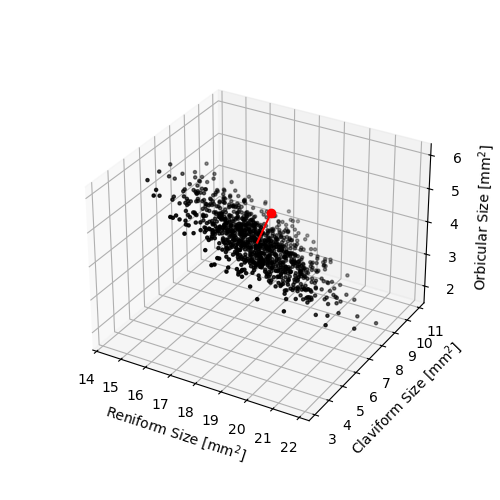

In [207]:
%matplotlib widget

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

# First, plot the points in black.
coords = moth_data.to_numpy()
(x, y, z) = coords.T
ax.scatter(x, y, z, c='k', marker='.')

# Since the PCs are mean-centered, we need to know the dataset mean to plot
# the first PC's arrow.
pc3_start = np.mean(coords, axis=0)

# Next, plot the third PC. Matplotlib doesn't currently support 3D arrows,
# so we plot it as a line with a dot at the end (the dot is at the end of the
# vector, not the start).
pc3_end = pc3_start + pca.components_[2]
xs = [pc3_start[0], pc3_end[0]]
ys = [pc3_start[1], pc3_end[1]]
zs = [pc3_start[2], pc3_end[2]]
ax.plot(xs, ys, zs, 'r-', zorder=10)
ax.plot(pc3_end[0], pc3_end[1], pc3_end[2], 'ro', zorder=10)

# Label the plot:
ax.set_xlabel(axlbls[0])
ax.set_ylabel(axlbls[1])
ax.set_zlabel(axlbls[2])

plt.show()

Given this observation&mdash;that there is approximately 0 variance along the final principal axis&mdash;it is sensible to reduce the dataset to just 2 dimensions. Clearly there are only two meaningful dimensions to the underlying data because the data lie in a 2D plane. Rather than plot the data in 3D, we can instead plot the data in 2D, but instead of using any of the dataset's original axes (i.e., an axis for each of the spots), we would use the first two PCs. These axes don't nearly correspond to individual spots, so they should not be labeled as such. A 2D representation is still useful, however, because it allows one to see the approximate distance between spots and the shape of their approximate distribution without needing to rotate the dataset in 3D. This is only slightly useful when dealing with 3D data, but in many real-world datasets, there are more than 3 dimensions, making visualization of the raw data in a single plot impossible. If the structure of the data can be approximated with just 2 dimensions, that can be very valuable.

Because PCA is often used in this way, it is considered one of the primary methods of **dimensionality reduction**. Other methods of dimensionality reduction that are related to PCA include [multidimensional scaling](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html), which we will not discuss in this course, and [locally linear embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html), which we will discuss in the next section.

## PCA: Conclusions

PCA is one of the most powerful and commonly used methods in the data scientist's toolkit. Without knowing anything about the data, one can use PCA to quickly assess which dimensions of a dataset contain the most variance and how that variance is partitioned along a set of "principal" axes that are all orthogonal.

PCA is often used to reduce the dimensionality of a dataset and can make high-dimensional datasets much easier to visualize. It is important when reducing the dimensions of a dataset to correctly label the axes of any visualization, however. The PCs do not correspond directly to individual axes of the original dataset; rather, they correspond to combinations of these axes.

The total variance in a dataset is partitioned by PCA into variances lying along the PCs. The first PC will always encapsulate the most variance, the second PC the next most, etc. Because variance adds across dimensions, the sum of the variances along each PC will be equal to the sum of variance in the entire dataset.